# Quick Start With HuggingFace
- GitHub: https://github.com/haotian-liu/LLaVA?tab=readme-ov-file#fine-tuning-with-local-gpus
- HuggingFace: https://huggingface.co/docs/transformers/model_doc/llava

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers==4.36.0
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 28.8 MB/s eta 0:00:00


In [3]:
import transformers
print(transformers.__version__)

4.36.0


In [4]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [5]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-13b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/77.2k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

In [6]:
# 이미지 폴더 압축 해제
import zipfile
file_name = "/content/drive/MyDrive/images.zip"
output_dir = "./"
zip_file = zipfile.ZipFile(file_name)
zip_file.extractall(path=output_dir)

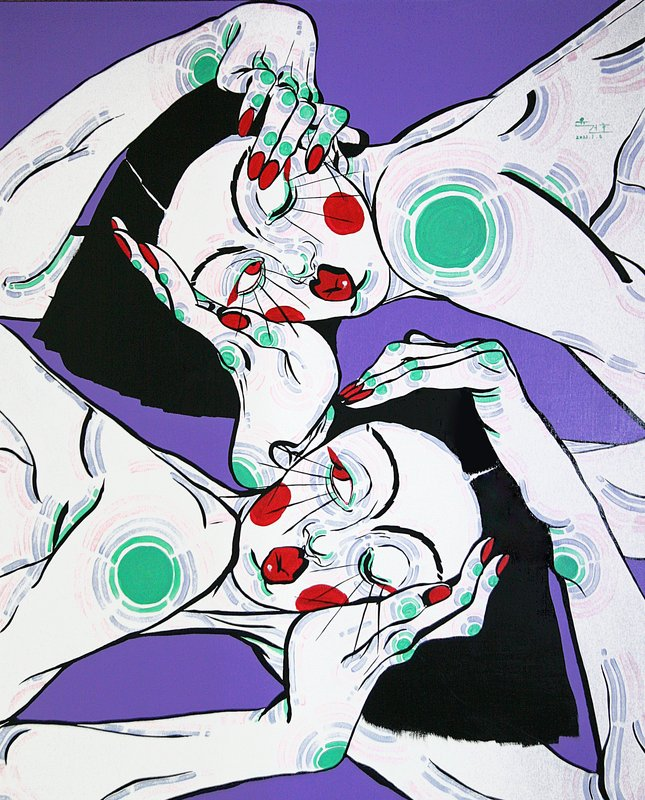

In [7]:
# 이미지 읽기
import requests
from PIL import Image
import os

data_path = "./images/"
image_paths = [os.path.join(data_path,img) for img in sorted(os.listdir(data_path))]

# 웹 이미지
# image_url = "https://file.mk.co.kr/meet/neds/2017/06/image_readtop_2017_381189_14968240852910169.jpg"
# image = Image.open(requests.get(image_url, stream=True).raw)

# 로컬 이미지
image_path = image_paths[4]
image = Image.open(image_path)

image

## 1. 키워드 추출 prompting
* prompt : What are the main objects in this picture? Just pick 3 WORDs
  * 키워드 수 3개 제한
  * [문제]
     * 감상포인트 < 객체
     * 추상화에서
     * 추출한 키워드와 이미지 매칭 안되는 경우

In [8]:
import re

In [9]:
# 프롬프트 답변
prompt = "USER: <image>\nWhat are the main objects in this picture? Just pick 3 WORDs\nASSISTANT:"
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 500})

# 키워드 추출
keywords = outputs[0]["generated_text"].split('ASSISTANT: ')[1].split(', ')

print(outputs[0]["generated_text"])
print()
print(keywords)

USER:  
What are the main objects in this picture? Just pick 3 WORDs
ASSISTANT: Nails, lips, and eyes

['Nails', 'lips', 'and eyes']


## 2. 좌표 추출 prompting

In [10]:
# 3. 키워드 바탕 객체 추출 프롬프트

# (1). 기본 프롬프트
# => 1개의 키워드 - 여러개의 좌표 매칭되어 난잡해짐
# prompt_for_coord =  "USER: <image>\nTell me the coordinate of {}, Sentence like (x1, y1, x2, y2)\nASSISTANT:".format(", ".join(keywords))

# (2). (1)번 문제 해결 위해 each one 추가. but 통하지 않는 그림 존재. 여러 그림 저장 후 실험해 봐야할듯.
# => 3개의 키워드는 추출했지만, 실제 그림에서 키워드를 찾지 못한 경우 답변에서 키워드가 생략되고 좌표만 출력된다.
# prompt_for_coord =  "USER: <image>\nTell me the each one coordinate of {}, Please Sentence like keyword :(x1, y1, x2, y2)\nASSISTANT:".format(", ".join(keywords))

# (3). (2)번 문제 해결 위해 프롬프트 수정
# prompt_for_coord =  "USER: <image>\nTell me the each one coordinate of {}. For example, if the one keyword is 'woman', the output must be 'woman: (x1, y1, x2, y2)'.\nASSISTANT:".format(", ".join(keywords))

# (4)
prompt_for_coord =  "USER: <image>\nTell me the each one coordinate of these keyword list [{}]. For example, if the one keyword is 'woman', the output must be 'woman: (x1, y1, x2, y2)\nASSISTANT:".format(", ".join(keywords))

##################################################################################################
outputs_coord = pipe(image, prompt=prompt_for_coord, generate_kwargs={"max_new_tokens": 500})
print(outputs_coord[0]["generated_text"])



RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#### 좌표 정제

In [ ]:
# 좌표 / 키워드
def extract_coordinates(text):
    text = text[0]["generated_text"]
    dic={}

    # 좌표 추출
    coord_pattern = r'\((.*?)\)'
    coord_matches = re.findall(coord_pattern, text)[1:]
    coordinates = [tuple(map(float, m.split(', '))) for m in coord_matches]
    print(coordinates)
    # 키워드 추출
    keyword_pattern = r'(\b\w+):'  # '단어:' 형태의 패턴
    keyword_matches = re.findall(keyword_pattern, text)[4:]

    # 딕셔너리 생성
    for i in range(len(coordinates)):
      dic[keyword_matches[i]] = coordinates[i]
    return dic


dic = extract_coordinates(outputs_coord)
print(dic)

#### 박스 그리기

In [ ]:
# 키워드 없이 좌표만 표시
from PIL import Image, ImageDraw
import copy
import random
#################################################################
# coords = [(0.085, 0.429, 0.125, 0.541)]
coords = [v for k,v in dic.items()]
# coords = [v for v in dic]
#################################################################
# 이미지 로드
img = copy.deepcopy(image)
width, height = img.size  # 이미지의 너비와 높이
print(coords)

# coords = [c*width if i%2==0 else c*height for i, c in enumerate(coords)]
coords = [[c*width if i%2==0 else c*height for i, c in enumerate(sublist)] for sublist in coords]
print(coords)


# 박스 그리기
draw = ImageDraw.Draw(img)
for c in coords:
  colors = [random.randint(0, 255) for _ in range(3)]
  draw.rectangle(c, outline=(colors[0],colors[1],colors[2]), width=3)
# 이미지 보기
img.show()
img

In [ ]:
#키워드 + 좌표 표시
from PIL import Image, ImageDraw,ImageFont
import copy
import random
def draw_box(dic,image):
  coords = [c for c in dic.values()]
  img = copy.deepcopy(image)
  width, height = img.size

  print(coords)
  # 이미지 크기에 맞게 좌표 변환
  coords = [[c*width if i%2==0 else c*height for i, c in enumerate(sublist)] for sublist in coords]
  print(coords)

  # 박스 그리기
  draw = ImageDraw.Draw(img)
  for i, c in enumerate(coords):
    colors = [random.randint(0, 255) for _ in range(3)]
    draw.rectangle(c, outline=(colors[0],colors[1],colors[2]), width=3)
    draw.text(c, keywords[i], colors[i])

  img.show()
  img

draw_box(dic,image)

### keyworkd, 좌표 추출 한번에 (진행중)

In [ ]:
import re
prompt = "USER: <image>\nWhat are the main objects in this picture? Just pick 3 WORDs\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 500})

keywords = outputs[0]["generated_text"].split('ASSISTANT: ')[1].split(', ')

print(keywords)